# Bigram Language Modeling using frequency counts for generating Onion-like News Headlines

Based on Andrej Karpathy's first half Youtube lecture [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, string
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path


import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Functions

In [2]:
def plot_top_words(ax, bigram_word_counts, top_n=20):
  df = pd.DataFrame(bigram_word_counts.most_common(n=top_n), columns=['Bigram', 'Counts'])
  sns.barplot(data=df, y='Bigram', x='Counts', ax=ax)

## Data Setup

In [3]:
try:
  onion_df = pd.read_csv('../../data/cleaned_onion_headlines.csv')
except FileNotFoundError:
  onion_df = pd.read_csv('../../data/original_onion_headlines.csv')

  onion_df['text'] = onion_df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
  onion_df['text'] = onion_df['text'].apply(str.lower)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'\$([0-9]+)', '\g<1> dollars', t))

  from num2words import num2words
  def convert_nums(text):
    nums = re.findall(r'\d+', text)
    converts = {num: num2words(num).replace('-', ' ') for num in nums}
    for num,word in converts.items():
      text = text.replace(num, word)
    return text
  onion_df['text'] = onion_df['text'].apply(convert_nums)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'[^a-z ]', '', t))
  onion_df['text'].replace('', np.nan, inplace=True)
  onion_df.dropna(inplace=True)
  onion_df.to_csv('../data/cleaned_onion_headlines.csv', index=None)
onion_df.shape

(14362, 1)

In [4]:
onion_df['length'] = onion_df['text'].apply(lambda t: len(t.split()))
onion_df['length'].describe()

count    14362.000000
mean        12.787077
std          5.495774
min          1.000000
25%          9.000000
50%         12.000000
75%         16.000000
max         53.000000
Name: length, dtype: float64

In [5]:
idx = 0
text = onion_df.iloc[idx]['text']
print(text)

entire facebook staff laughs as man tightens privacy settings


In [6]:
idx = np.random.randint(len(onion_df))
text = onion_df.iloc[idx]['text']
print(text)

biden scales down two dollars trillion climate plan to single reusable grocery bag


## Bigram Language Model

In [7]:
texts = onion_df['text'].tolist()
vocab = ['<s>', '<u>'] + sorted(set(' '.join(texts).split()))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
print(len(vocab))

21754


In [8]:
bigram_idx_counts = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
bigram_word_counts = Counter()

for text in texts:
  words = ['<s>'] + text.split() + ['<s>']
  for word1, word2 in zip(words, words[1:]):
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    bigram_idx_counts[idx1, idx2] += 1
    bigram_word_counts[f'{word1} {word2}'] += 1

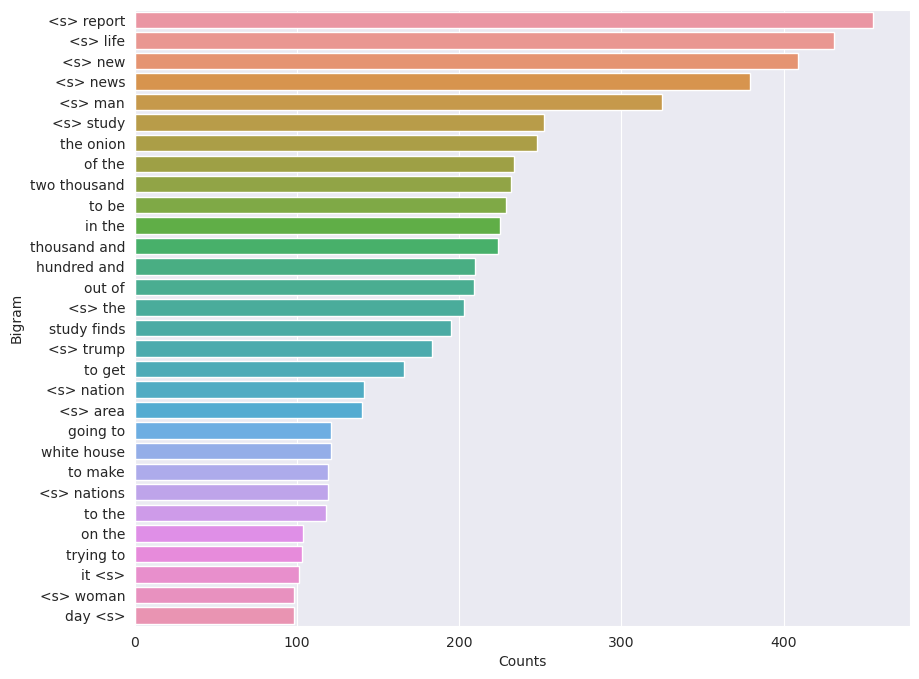

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_top_words(ax, bigram_word_counts, top_n=30)

In [10]:
bigram_idx_counts[0]

tensor([ 0,  0, 41,  ...,  0,  0,  0], dtype=torch.int32)

In [11]:
idx = np.random.randint(len(bigram_idx_counts))
p = bigram_idx_counts[idx].float()/bigram_idx_counts[idx].sum()
p

tensor([0.0769, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

In [12]:
bigram_probs = bigram_idx_counts.float()/bigram_idx_counts.sum(axis=1, keepdim=True)

In [13]:
bigram_probs[idx] == p

tensor([True, True, True,  ..., True, True, True])

In [14]:
g = torch.Generator().manual_seed(2468975301)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'the'

In [15]:
g = torch.Generator().manual_seed(2468975301)
n_headlines = 20
for _ in range(n_headlines):
  # print('*'*50)
  idx = 0
  ai_onion = []
  while True:
    idx = torch.multinomial(bigram_probs[idx], num_samples=1, replacement=True, generator=g).item()
    # idx = torch.multinomial(torch.ones(len(vocab))/len(vocab), num_samples=1, replacement=True, generator=g).item()
    ai_onion.append(itos[idx])
    if idx == 0 or len(ai_onion) > 25:
      break
  print(' '.join(ai_onion[:-1]))    

scientists warn ionosphere one dollars
couple to moderate presidential motorcade to take naps in plastic taiwanesemade toy crouched naked women remain
albanian village who finally catches bad mike pence straining to places star wars film standards for replacing the onions four dollarsnine million copies of having
woman forced to make my email offers business cards black lives vicariously through a legend lives vicariously through this year
american people get the bathroom attendant offers witty remark during the world know the schools lacking basic facts about that before declaring asshole
new profile picture
road bill making iphone for the kid makes more americans of isis and in chicken because its place of chinese government shouldnt smell old guys
life this song addressing sexual indiscrimination
must see whatever animal kingdom looking at this guy this incredible check
nomakeup look busy this and crash
andy reid furious after games seemed perfectly camouflage
man figures actress fo

GOAL: Maximize the liklihood of the data w.r.t model parameters (statistical modeling). This is equivalent to:
1. maximizing the log liklihood (because log is monotonic)
2. minimizing the negative log liklihood
3. minimizing the average negative logliklihood

In [16]:
log_likelihood = 0.
n = 0
for text in texts:
  words = ['<s>'] + text.split() + ['<s>']
  for word1, word2 in zip(words, words[1:]):
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    prob = bigram_probs[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{word1} {word2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {-log_likelihood/n:0.4f}")

log_likelihood=tensor(-704520.9375)
nll=tensor(704520.9375)
average nll 3.5580


In [17]:
cnn_headline = 'Trump goes to Supreme Court over Mar a Lago search and seizure of documents'.lower()
onion_headline = 'High Schoolers Given Detention For Cutting Class During Active Shooting'.lower()

In [18]:
cnn_headline

'trump goes to supreme court over mar a lago search and seizure of documents'

In [23]:
log_likelihood = 0.
n = 0
for text in [cnn_headline]:
  words = ['<s>'] + text.split() + ['<s>']
  for word1, word2 in zip(words, words[1:]):
    if word1 not in vocab:
      word1 = '<s>'
    if word2 not in vocab:
      word2 = '<s>'
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    prob = bigram_probs[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{ch1}{ch2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {-log_likelihood/n:0.4f}")

log_likelihood=tensor(-inf)
nll=tensor(inf)
average nll inf
